# Predicting Song Genre from Song Lyrics

### Predicting using Naive Bayes (Part 2)

The data is an accumulation of 380,000+ lyrics from the website MetroLyrics.com. We have multiple artists in 10 varying genres ranging from Pop & Rock to Indie & Folk. The songs range from years 1960 to 2016. 

The goal of the project was, as said in title, to predict genre based on the lyrics. In order to tackle this problem, this involved doing natural language processing in order to effectively analyze the lyrics. 

In [21]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

In [22]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Manda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Manda\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Manda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## This is the cleaned lyrics data from Part 1

In [4]:
df2 = pd.read_csv('lyrics_final.csv', delimiter=',')

### Split Data for Train & Test

In [7]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df2['lyrics_final'],df2['genre'],test_size=0.3)

# What is TFIDF Vectorizer - Measuring Originality

### TFIDF - term-frequency x inverse document-frequency

TFIDF takes an occurence of a token (i.e. a lemmatized word) in the data and scales down the impact of these tokens that occur very frequently in our data. In our example, this means a lemmatized word would be "less informative" if it occured more frequently across all genres. A key example of this would be the word "love".

The tf-idf is a statistic that increases with the number of times a word appears in the document (lyrics of a song), penalized by the number of genres in the data that contain that word.

However, if a lemmatized word appeared more frequently in a particular genre it would be more valuable/original, and we would  capture that originality which will help us predict the genre of that that group of words. 


------------------

max_df - ignoring terms that have a document frequency higher than 0.5   
.fit() - fits the vocabulary and term frequencies of word-vector   
.transform() - using "fit()" calculation parameters, apply the transformation to a dataset.  
  

In [8]:
Tfidf_vect = TfidfVectorizer(sublinear_tf=True, max_features=10000, max_df=0.7) #igoring
Tfidf_vect.fit(df2['lyrics_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

### What is a TFIDF Vector?

First Column: Document index (song lyrics) 

Second Column: Specific word-vector index (lemmatized word in lyrics)  

Third Column: TFIDF score ("originality score") for word in lyrics

----------------

Here is an example of what a tfidf sparse matrix looks like:

In [9]:
#vocab dictionary (and number of occurences)
print(Tfidf_vect.vocabulary_)

{'like': 5019, 'gasoline': 3490, 'ever': 2894, 'go': 3632, 'back': 547, 'another': 320, 'day': 2132, 'road': 7339, 'never': 5904, 'make': 5256, 'sin': 7937, 'line': 5037, 'read': 7063, 'across': 56, 'field': 3126, 'little': 5059, 'known': 4774, 'say': 7571, 'get': 3553, 'accelerate': 35, 'floor': 3229, 'observe': 6056, 'light': 5012, 'foot': 3274, 'pass': 6340, 'time': 8918, 'try': 9129, 'motionless': 5682, 'revive': 7265, 'blinding': 878, 'different': 2353, 'route': 7405, 'give': 3591, 'find': 3155, 'hidden': 4033, 'away': 520, 'year': 9912, 'four': 3327, 'think': 8835, 'first': 3174, 'clear': 1569, 'gain': 3460, 'control': 1800, 'bob': 922, 'rock': 7353, 'as': 420, 'certain': 1377, 'sign': 7912, 'see': 7662, 'way': 9643, 'breakin': 1034, 'seem': 7668, 'cover': 1880, 'know': 4770, 'check': 1439, 'fact': 2989, 'tell': 8751, 'habit': 3810, 'pick': 6509, 'fault': 3063, 'fake': 3014, 'lot': 5137, 'mad': 5217, 'sure': 8572, 'would': 9860, 'sunday': 8542, 'dull': 2619, 'allow': 204, 'awful'

### TFIDF Output

We see here a more tangible look at the tfidf sparse matrix using .get_feature_names(). get_features_names() shows, in alphabetical order, the words of the word-vectors that would be in column 2.

The print statement is what "Tfidf_vect.fit(df2['lyrics_final'].head(2)).get_feature_names()" output looks like but in a more visually friendly way

In [16]:
#these are examples of what the second column of tfidf_vect represents
#Tfidf_vect.fit(df2['lyrics_final'].head(2)).get_feature_names()

In [17]:
print(['accelerate', 'across', 'allow', 'another', 'as', 'away', 'awful', 'back', 'balch', 'blinding', 'bob', 'breakin', 'certain', 'check', 'clear', 'coca', 'cola', 'cold', 'control', 'cover', 'day', 'different', 'dull', 'ever', 'fact', 'fake', 'fault', 'feel', 'field', 'find', 'first', 'fish', 'floor', 'foot', 'four', 'friend', 'gain', 'gasoline', 'give', 'glass', 'go', 'habit', 'hidden', 'impossible', 'known', 'light', 'line', 'little', 'lot', 'mad', 'mean', 'miserable', 'mola', 'motionless', 'never', 'notice', 'observe', 'party', 'pass', 'people', 'pick', 'pretty', 'read', 'revive', 'road', 'rock', 'route', 'say', 'see', 'seem', 'shaky', 'sign', 'sin', 'since', 'start', 'sunday', 'sure', 'talk', 'tell', 'think', 'time', 'urethane', 'watch', 'water', 'way', 'would', 'year'])

['accelerate', 'across', 'allow', 'another', 'as', 'away', 'awful', 'back', 'balch', 'blinding', 'bob', 'breakin', 'certain', 'check', 'clear', 'coca', 'cola', 'cold', 'control', 'cover', 'day', 'different', 'dull', 'ever', 'fact', 'fake', 'fault', 'feel', 'field', 'find', 'first', 'fish', 'floor', 'foot', 'four', 'friend', 'gain', 'gasoline', 'give', 'glass', 'go', 'habit', 'hidden', 'impossible', 'known', 'light', 'line', 'little', 'lot', 'mad', 'mean', 'miserable', 'mola', 'motionless', 'never', 'notice', 'observe', 'party', 'pass', 'people', 'pick', 'pretty', 'read', 'revive', 'road', 'rock', 'route', 'say', 'see', 'seem', 'shaky', 'sign', 'sin', 'since', 'start', 'sunday', 'sure', 'talk', 'tell', 'think', 'time', 'urethane', 'watch', 'water', 'way', 'would', 'year']


# Naive Bayes - Multinomial

With tfidf, the term frequencies are used to compute the maximum-likelihood estimate based on the training data to estimate the class-conditional probabilities in the multinomial model. 

In [23]:
#TFIDF
Naive = naive_bayes.MultinomialNB(alpha = .01)
Naive.fit(Train_X_Tfidf,Train_Y)
predictions_NB = Naive.predict(Test_X_Tfidf)
print("Naive Bayes Accuracy Score TFIDF:",accuracy_score(predictions_NB, Test_Y)*100)


Naive Bayes Accuracy Score TFIDF: 57.09416276097146


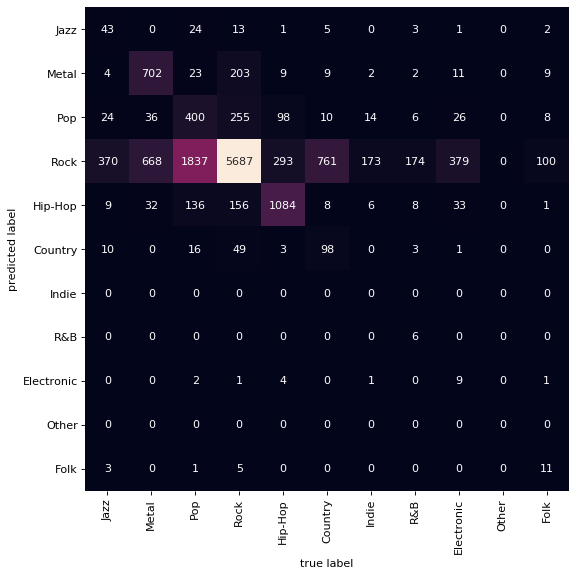

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

genres = ['Jazz','Metal', 'Pop',  'Rock', 'Hip-Hop', 'Country', 'Indie','R&B', 'Electronic', 'Other', 'Folk']
mat = confusion_matrix(Test_Y, predictions_NB, genres)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=genres, 
    yticklabels=genres
)
plt.xlabel('true label')
plt.ylabel('predicted label');
